In [1]:
import ast
import os
import itertools
from collections import Counter
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from preprocessing import * 
from analysis import *


warnings.filterwarnings('ignore')

In [2]:
# Read data
games = pd.read_csv("Data/games_detailed_info.csv", index_col=0) # review stats
# 1. Remove columns with > 20% of NA values 
key_columns = keep_columns_with_few_na(games)
# 2. Remove redundant/unnecesary columns
unnecessary_columns = ["type", "thumbnail", "image", "suggested_num_players", "suggested_playerage", 
                       "suggested_language_dependence"]
key_columns = [x for x in key_columns if x not in unnecessary_columns]
# 3. Rename confusing column names
games = games.loc[:,key_columns]
games.rename(columns={"primary": "name", "usersrated": "numratings", "average": "avgrating",
                      "boardgamecategory": "category", "boardgamemechanic": "mechanic", 
                      "boardgamedesigner": "designer", "boardgamepublisher": "publisher", 
                      "bayesaverage": "bayesavgrating", "Board Game Rank": "rank", 
                      "stddev": "stdrating", "median": "medianrating",
                      "owned": "numowned", "trading": "numtrades", "wanting":"numwants", 
                      "wishing": "numwishes"}, inplace=True)
# 4. Parse columns with list values
list_colnames = ["category", "mechanic", "designer", "publisher"]
games = clean_string_format_columns(games, list_colnames)

## Trend anlaysis

### 1. Overall #games published over years

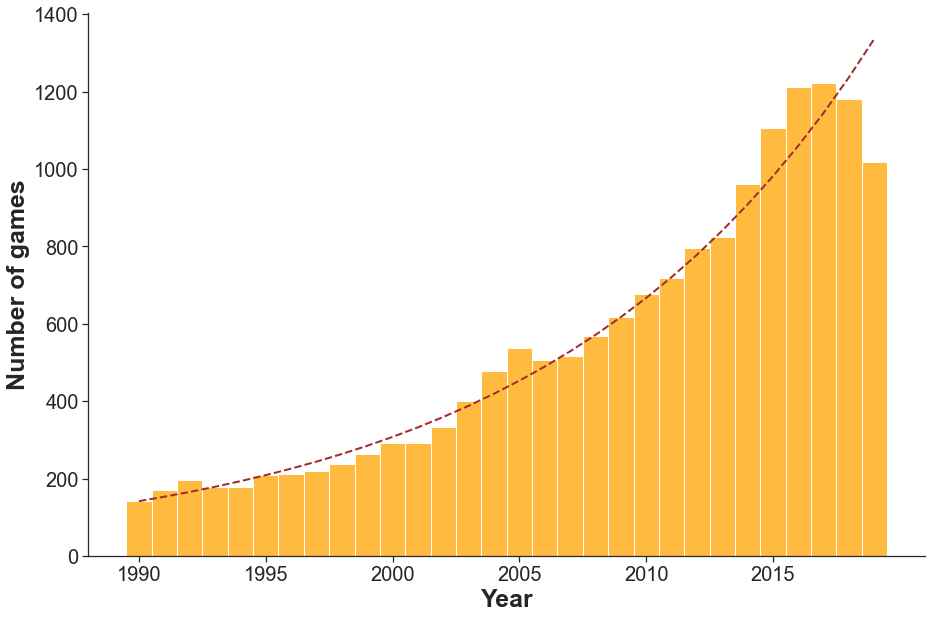

In [3]:
plot_published_games_over_years(games, 1990, 2019, True)

### 2. Average values of game attributes over years

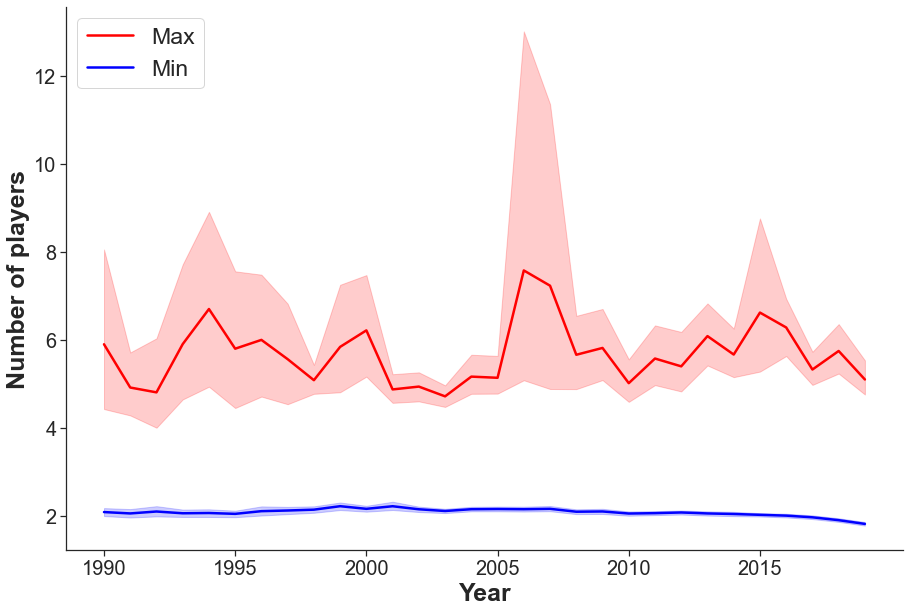

In [4]:
plot_min_max_attributes_over_years(games, 1990, 2019, "minplayers", "maxplayers", "Number of players")

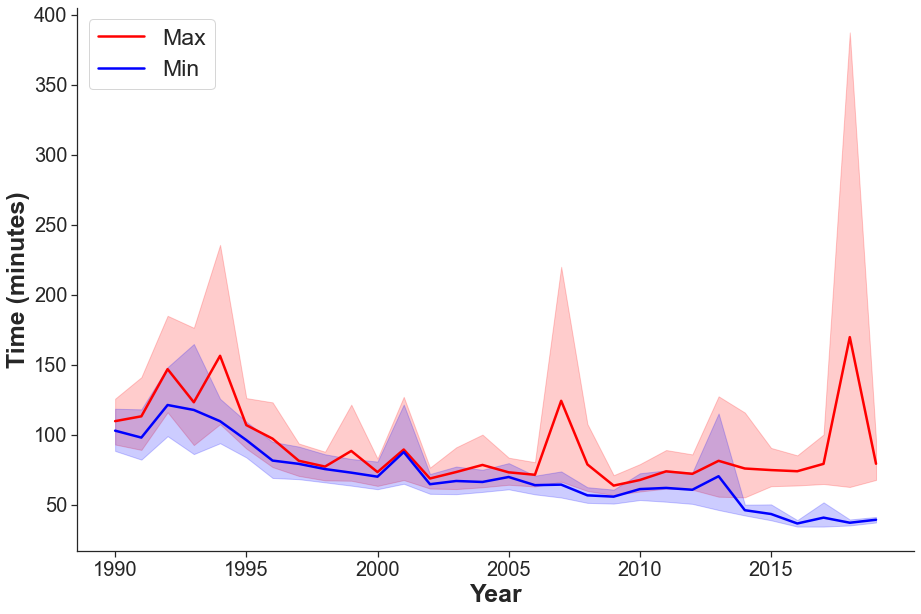

In [5]:
plot_min_max_attributes_over_years(games, 1990, 2019, "minplaytime", "maxplaytime", "Time (minutes)")

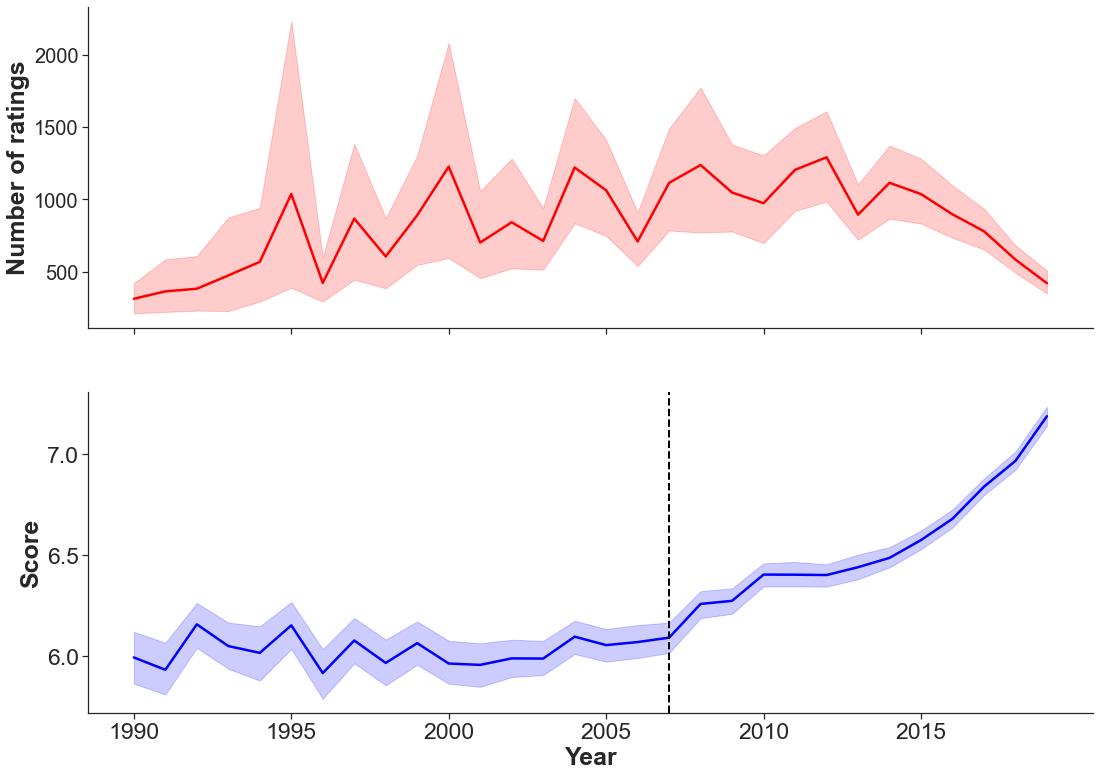

In [6]:
plot_ratings_over_years(games, 1990, 2019, 2007)

## Comparison before & after 2007

### 1. Game description word clouds

In [7]:
ds1 = games.loc[games["yearpublished"] <= 2007, "description"]
ds2 = games.loc[games["yearpublished"] > 2007, "description"]

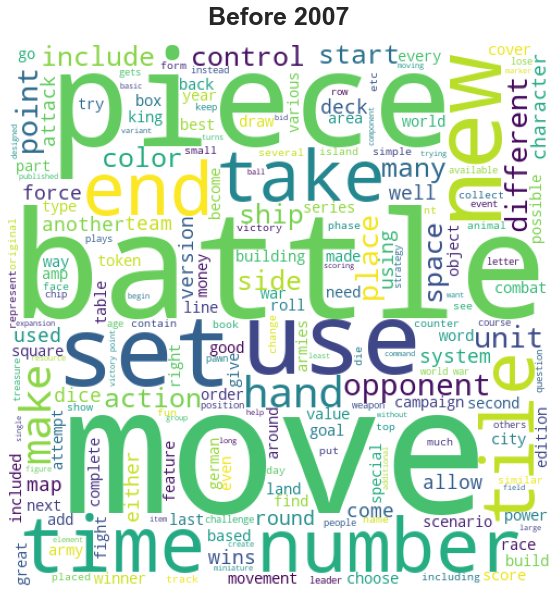

In [8]:
generate_word_cloud(ds1, title="Before 2007")

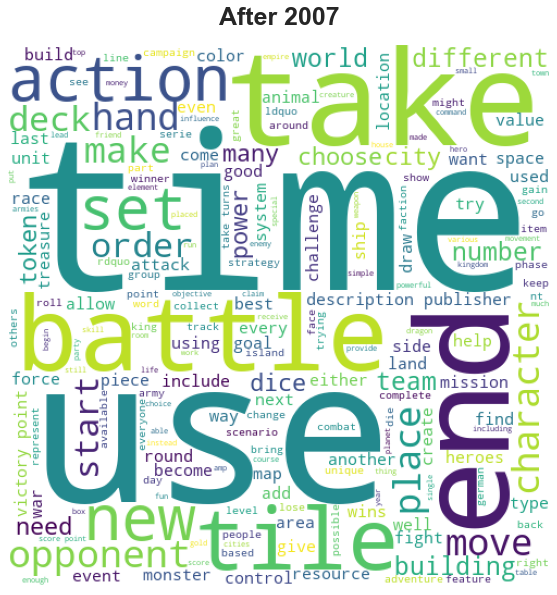

In [9]:
generate_word_cloud(ds2, title="After 2007")

### 2. Top 10 categories/mechanics

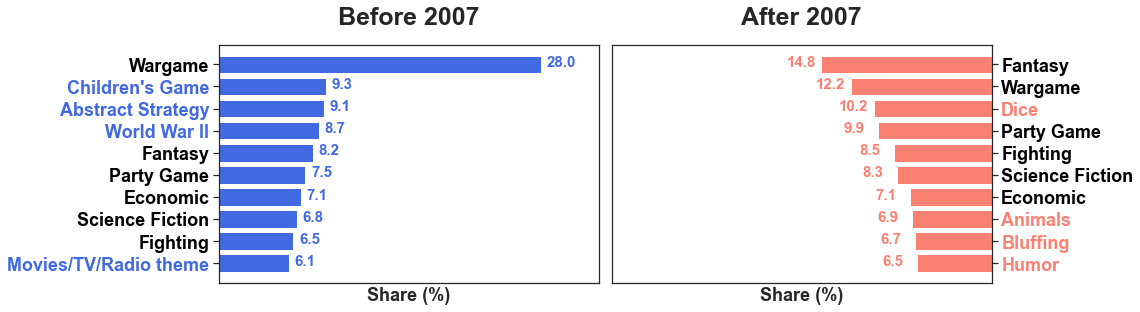

In [10]:
df1, df2, cat_cnts1, cat_cnts2, cat_inters = compare_top_ten_items(games, "category", True, ["'Card Game'"])

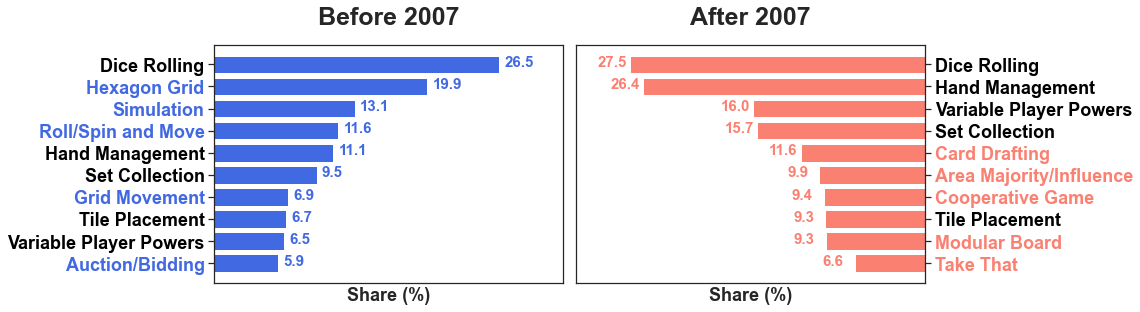

In [11]:
df1, df2, mec_cnts1, mec_cnts2, mec_inters = compare_top_ten_items(games, "mechanic", True, [])

### 3. Transition of overlapping categories/mechanics

In [12]:
population_size1 = df1.shape[0]
population_size2 = df2.shape[0]

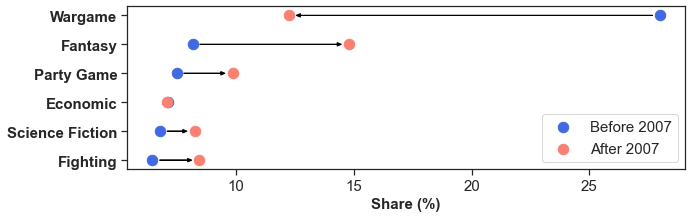

In [13]:
plot_changed_frequencies(cat_inters, cat_cnts1, cat_cnts2, population_size1, population_size2, 2007)

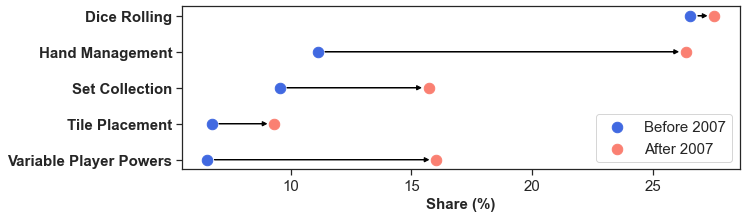

In [14]:
plot_changed_frequencies(mec_inters, mec_cnts1, mec_cnts2, population_size1, population_size2, 2007)